<a href="https://colab.research.google.com/github/DataScienceForPhysicists2025/blob/main/09_NeuralQuantumStates/NeuralQuantumStates_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Introduction to Neural Quantum States (NQS)**


#### **What are NQS?**

- A class of **variational wave functions** that use **artificial neural networks** to represent quantum many-body states.
- G. Carleo and M. Troyer first introduced this approach in 2017 (Science 355, 602–606).

#### **How are NQS trained?**

- **Variational principle:** Recall that given some Hamiltonian $\hat{H}$ and any wave function $\Psi(x)$ (with the appropriate symmetries), the expectation value
$$ \langle E \rangle \equiv  \frac{\langle \Psi | \hat{H} | \Psi \rangle}{\langle \Psi | \Psi \rangle} \geq E_0$$
where $E_0$ is the true ground state energy.
- **Variational wave function:** Propose some "trial" wave function $\Psi(x; \theta)$ dependent on some parameters $\theta$ that are tuned to minimize the system's energy. We then must compute the expectation value
$$\langle E(\theta) \rangle \equiv \frac{\int dx \  \Psi^*(x;\theta) \  \hat{H}\  \Psi(x;\theta)}{\int dx \  \Psi^*(x;\theta) \  \Psi(x;\theta)}.$$
- **Monte Carlo techniques:** The integral above becomes expensive to compute as the spatial dimension or number of particles increases. Monte Carlo integration is used to efficiently estimate the energy $\langle E(\theta) \rangle$ and its gradient $\nabla_{\theta} \langle E(\theta) \rangle$.
- **Gradient-based optimization:** The energy is minimized using gradient descent methods, including second-order approaches like stochastic reconfiguration. The simplest parameter update possible is
$$\theta \mapsto \theta - \eta \nabla_{\theta} \langle E(\theta) \rangle,$$
where $\eta$ is the "learning rate".
- **Training data:** The NQS does not rely on external datasets; instead, it generates its own training data and learns directly from it.
- **Variational Monte Carlo:** This approach combines all the above concepts into a method called Variational Monte Carlo (VMC).
- **Neural Quantum States:** Artificial neural networks can be used to write down a flexible variational wave function. The main distinction from traditional VMC is that computing the energy gradient requires numerical differentiation of the NQS via backpropagation.

#### **The Algorithm**

1. **Generate training data:** Sample configurations from the probability distribution given by the wave function $x \sim |\Psi(x; \theta)|^2$.
2. **Compute the cost and gradient:** Approximate the energy $\langle E(\theta) \rangle$ and its gradient $\nabla_{\theta} \langle E(\theta) \rangle$ using the sampled configurations.
3. **Update the parameters:** Apply some gradient descent method to the parameters $\theta$.
4. Repeat steps 1-3 until converged.


#### **Why are NQS useful?**

- **Expressive power:** NQS can efficiently approximate bound states of highly correlated quantum systems
- **Scalability:** NQS scale to larger systems polynomially, in contrast to the factorial or exponential scaling seen in many other many-body methods.
- **Generalizability:** Unlike problem-specific ansätze, they can adapt to different types of systems with ease.
- **Sign problem:** Potential applications in mitigating the sign problem in Quantum Monte Carlo.

#### **Goals of this notebook**

- Train a NQS on a simple toy problem: a single particle in a one-dimensional harmonic oscillator.
- Show how the design of NQS can enforce specific wave function properties.
- Gain familiarity with feedforward neural networks, a widely used architecture known for its efficient training.
- Extend the toy problem to custom potential traps.

# **Background**

## **Feedforward Neural Networks**

We can build a feedforward neural network (FNN) by alternating between trainable affine transformations of the form

$$\vec{x}_{out} = W \vec{x}_{in} + \vec{b},$$

and nontrainable, element-wise nonlinear activation functions

$$\vec{x}_{out} = f(\vec{x}_{in}),$$

where $W$ is a matrix and $\vec{b}$ is a vector of parameters to be optimize later. In contrast, we select activation functions, such as $f(x) = \tanh(x)$, before training and keep them fixed throughout the training process.

This alternating process gives the following structure:

\begin{align}
\vec{h}_0 &= \vec{x}_{in},\\
\vec{h}_\ell &= f(W_\ell \vec{h}_{\ell-1} + \vec{b}_{\ell}), \ \text{for} \ \ell = 1, ..., L,\\
\vec{x}_{out} &= W_{L+1} \vec{h}_L + \vec{b}_{L+1},
\end{align}

where $L$ is the number of hidden layers. In our case, no activation function will be applied to the output layer, allowing for an unrestricted output range.

The trainable parameters of the entire network are $\theta = (W_1, \vec{b}_1, W_2, \vec{b}_2, ..., W_{L+1}, \vec{b}_{L+1})$. The fixed hypterparameters are the activation functions, the number of layers, and the dimensions of each layer.

## **Designing the NQS**

For a smooth, confining potential, a one-dimensional, one-particle ground-state wave function must...
1. Be continuous.
2. Have a continuous first derivative.
3. Have a continuous second derivative if the potential is at least twice differentiable.
4. Be positive definite.
5. Be normalizable and bound, meaning it decays to zero at $|x|\rightarrow \infty$.

If $F(x)$ is an unconstrained neural network, we need to carefully choose activation functions and transformations to enforce or strongly encourage the desired wave function properties.

- Continuity and smoothness: A twice-differentiable, continuous activation function is sufficient for properties 1-3.

- Positive definiteness: Passing the network output through a transformation like $\exp(F(x))$ ensures positivity

- Boundedness can be strongly encouraged by multiplying the positive definite function by an envelope, such as $\exp(-c x^2)$, where $c > 0$ is a small hyperparameter.

With these considerations, a natural choice for a NQS is:
$$\Psi(x)=\exp(F(x)−cx^2)$$

For numerical stability and mathematical convenience, it is better to work in terms of

$$\log \Psi(x) = F(x)−cx^2.$$

Note: Explicit normalization is not required for this construction.


Next, make sure you download the provided `nqs_utils.py` file, which contains four useful classes and a function to visualize the training process.

## **Monte Carlo Sampling**

Suppose we want to sample from a probability distribution $P(x)$, but we only know it up to a normalization constant:

$$P(x) = \frac{1}{Z} p(x),$$

where $p(x)$ is the unnormalized probability density and $Z$ is an unknown or intractable normalization factor

$$ Z = \int dx p(x).$$

Markov Chain Monte Carlo (MCMC) is a method for generating samples from a probability distribution by constructing a Markov chain—a sequence where each new sample depends only on the previous one. This approach is especially useful because it allows us to sample from $P(x)$ without needing to compute the normalization factor $Z$.

Here's a sketch of the algorithm:

1. Initialize: Start with a random initial state $x$.
2. Propose: Generate a new candidate state $x'$ by randomly perturbing the state $x$ using a symmetric proposal distribution (e.g. a Gaussian centered at $x$.)
3. Accept or reject: Compute the acceptance probability
$$A = \min\left( 1, \frac{p(x')}{p(x)} \right).$$
    - Accept the candidate with probability $A$ by setting $x = x'$

    - Otherwise, reject the new state $x'$ by keeping $x$ unchanged.
4. Repeat steps 2 and 3 to generate a sequence of samples.

This process produces samples distributed according to $P(x)$ over time.




## **Monte Carlo Integration for Observables**

Suppose we want to compute the expectation value of some operator $\hat{O}$ using an **unnormalized** wave function $\Psi(x)$:

$$\langle O \rangle \equiv \frac{\langle \Psi | \hat{O} | \Psi \rangle }{\langle \Psi | \Psi \rangle} = \frac{\int dx \ \Psi^*(x) \ \hat{O} \ \Psi(x)}{\int dx \ \Psi^*(x) \ \Psi(x)}$$


Let us multiply the numerator by $1 = \frac{\Psi(x)}{\Psi(x)}$. Then,


$$\langle O \rangle = \frac{\int dx \ \Psi^*(x) \ \hat{O} \ \Psi(x)}{\int dx \ \Psi^*(x) \ \Psi(x)} = \frac{\int dx \ \Psi^*(x) \Psi(x) \frac{1}{\Psi(x)} \ \hat{O} \ \Psi(x)}{\int dx \ \Psi^*(x) \ \Psi(x)}$$

Recognize that the quantity

$$ \frac{\Psi^* (x) \  \Psi(x)}{\int dx \ \Psi^*(x)\  \Psi(x)}  = \frac{|\Psi(x)|^2}{\int dx \ |\Psi(x)|^2}$$

is a normalized probability distribution. If we are able to pull samples from this normalized probability distribution, then we can estimate the expectation as a discrete average over "local" observable quantities:

$$\langle O \rangle \approx \frac{1}{N}\sum_{i = 1}^N \frac{1}{\Psi(x_i)} \ \hat{O} \ \Psi(x_i),$$

where $x_i \sim |\Psi(x)|^2$.



## **Using `JAX`**

To ensure our training runs efficiently within this session, we will use Google's `JAX`. If you're new to `JAX`, don’t worry—we're simply using it to speed up computations and make differentiation easier.

We will use the following key features:
1. **`jax.jit` (Just-in-Time Compilation)** – Compiles functions using XLA (Accelerated Linear Algebra) for faster execution. When you decorate a function with `@jax.jit`, it gets compiled on the first run and stored in cache, making subsequent calls much faster. This is especially useful for functions that are called repeatedly.
2. **`jax.vmap` (Vectorized Mapping)** – Applies a function efficiently across batches of inputs. Rather than using a loop to evaluate the function multiple times or relying on array broadcasting for elementwise operations, `jax.vmap` enables simultaneous processing of all inputs in a vectorized manner, improving performance.
3. **`jax.grad` (Automatic Differentiation)** – Automatically computes gradients, simplifying the differentiation process and eliminating the need for manual derivations.

To use these features, we’ll work with **`jax.numpy`**, which provides a `NumPy`-like interface optimized for `JAX`'s computation model. Most `NumPy` functions have a corresponding `JAX` counterpart that works similarly but is designed for better performance with `JAX`.

Unlike `NumPy`, `JAX` doesn’t maintain a global random state. Instead, it uses **PRNG** (Pseudo-Random Number Generator) keys to explicitly manage randomness. To generate random numbers, you first create an initial key:

    seed = 317
    key = jax.random.PRNGKey(seed)

Whenever you need to generate random numbers, you split the key to create a new subkey, then pass that subkey into the `jax.random` function:

    key, subkey = jax.random.split(key)
    rand_value = jax.random.normal(subkey)

By splitting the key, you ensure that each random number generation is independent, which is important for reproducibility and parallel computations.

## **Useful links**

#### [Installing JAX](https://docs.jax.dev/en/latest/installation.html)

#### [Common gotchas in JAX](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html)

#### [Just-in-time compilation](https://docs.jax.dev/en/latest/jit-compilation.html)

#### [Automatic differentiation](https://docs.jax.dev/en/latest/automatic-differentiation.html)

#### [Pseudorandom numbers](https://docs.jax.dev/en/latest/random-numbers.html)

#### [Working with pytrees](https://docs.jax.dev/en/latest/working-with-pytrees.html)

# **Getting started**



#### **Dependencies**
The core code for this project is still fairly large, with most of it contained in `nqs_utils.py`. There are many ways to structure and optimize the implementation, but I have chosen to use `JAX`. For more information on using `JAX`, see the **Appendix**. If you need to install `JAX` and `optax` (an optimization library built on JAX), run the cell below.

In [ ]:
!python --version
!pip install -U jax jaxlib
!pip install optax ffmpeg

Python 3.11.11
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=b0dd7b7a66087d42af10a881a611ae4b28737bb0f0c2f7bf052a29f3e3b37eb6
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
print(jax.__version__)

import time
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='html5')

0.5.2


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('nqs_utils.py','wb').write(src)

Saving nqs_utils.py to nqs_utils.py


12960

In [ ]:
from nqs_utils import NeuralQuantumState, Hamiltonian, Sampler, Optimizer, animate

Here's a description of the inputs to these classes.

#### **`NeuralQuantumState`**
Constructs the internal neural network and defines the variational wave function.
1. `layers`: A *list of integers* defining the number of neurons in each layer of the neural network. For our purposes, there should be at least 3 elements of this list, with the first and last fixed at 1.
2. `activation`: A *callable function* defining the nonlinear activation function for the hidden layers, e.g. `jnp.tanh`, `jax.nn.gelu`, `jax.nn.swish`.
3. `conf`: A small positive *floating-point number* that defines the Gaussian envelope of the wave function, helping it satisfy the boundary conditions for a bound state. A smaller value causes the initial wave function to resemble a uniform distribution, while a larger value makes it more similar to a Gaussian distribution. Typical values range from 0.01 to 0.05.

#### **`Sampler`**
Samples configurations (positions of the single particle) from an instance of the `NeuralQuantumState` class.
1. `nchains`: The number of independent Markov chains used for sampling. Typical values range from 100 - 1000 for the 1D problem.
2. `nsamples_per_chain`: The number of samples generated per chain. Typical values range from 10 - 1000 for the 1D problem.
3. `neq`: The number of equilibration steps before starting to collect samples. Typical values range from 10 - 100.
4. `nskip`: The number of steps skipped between consecutive samples to reduce autocorrelation. Typical values range from 10 - 100.
5. `sigma_step`: The Gaussian step size used in the Metropolis-Hastings sampling process. The typical size depends largely on the shape of the potential. For the harmonic oscillator
6. `sigma_init`: The Gaussian width of the initial position values for the chains.
7. `wavefunction` – The `NeuralQuantumState` instance used to compute probabilities for the sampling process.



#### **`Hamiltonian`**
Computes the expectation value of the energy and its gradient.
1. `wavefunction`: The `NeuralQuantumState` instance needed to compute the kinetic energy and the gradient with respect to trainable parameters.
2. `potential`: A callable function defining the potential energy of the system.


#### **`Optimizer`**

Puts everything together. Trains the NQS given some potential.

1. `learning_rate`: The step size for updating the wavefunction parameters during optimization. Typical values are 0.001 - 0.01.
2. `wavefunction`: The `NeuralQuantumState` instance whose parameters will be optimized.
3. `sampler`: The `Sampler` instance responsible for generating training data for optimization.
3. `hamiltonian`: The `Hamiltonian` instance used to compute the system’s energy and gradient.



---



# **Toy Problem: 1D Harmonic Oscillator**

We begin with the simple system of **one particle in a 1D harmonic oscillator trap** for the following reasons:
- **Single particle:** No need to worry about the symmetries required for identical particles (crucial for multi-particle systems).
- **One-dimensional:** The wave function is easy to visualize and track as it evolves.
- **Exactly solvable:** This allows us to compare our results with the true ground state energy and wave function.

In units of $\hbar=m=\omega=1$, the Hamiltonian is given by

$$\hat{H} = -\frac{1}{2} \frac{\partial^2}{\partial x^2} + \frac{1}{2} x^2,$$

where $x$ denotes the position of the particle. The exact ground state energy and wave function are well known:
$$E_0 = \frac{1}{2}, \ \ \ \Psi_0(x) \propto e^{-x^2 / 2}.$$



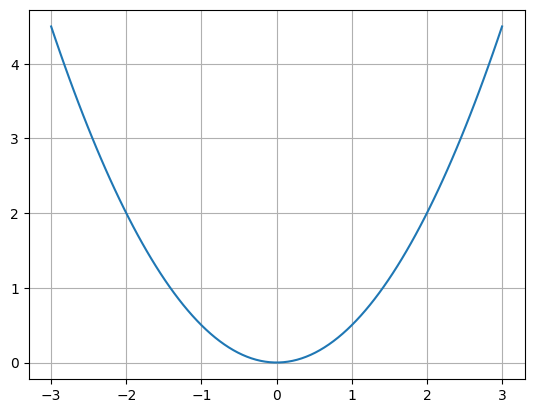

In [ ]:
@jax.jit
def harmonic_oscillator(x):
    return 0.5 * x**2


x = jnp.linspace(-3, 3, 100)
plt.plot(x, harmonic_oscillator(x))
plt.grid()
plt.show()

In [ ]:
layers = [1, 16, 16, 1]
activation = jax.nn.gelu
conf = 0.01
nopt = 101
nbins = 100
nchains = 400
nsamples_per_chain = 50
neq = 20
nskip = 10
sigma_step = 1.0
sigma_init = 1.0
learning_rate = 0.005
seed = 317
key = jax.random.PRNGKey(seed)

wavefunction = NeuralQuantumState(layers, activation, conf)
sampler = Sampler(nchains, nsamples_per_chain, neq, nskip, sigma_step, sigma_init, wavefunction)
hamiltonian = Hamiltonian(wavefunction, harmonic_oscillator)
optimizer = Optimizer(learning_rate, wavefunction, sampler, hamiltonian)

key, subkey = jax.random.split(key)
params = wavefunction.build(subkey)

ti = time.time()
harmonic_oscillator_training = optimizer.train(nopt, nbins, subkey, params)
tf = time.time()

print(f"Total training time = {tf-ti:10.3e} sec.")

Number of trainable parameters =  321

 iter      avg E      err E       time
    0  2.982e+00  3.392e-02  5.412e+01
   10  1.029e+00  1.153e-02  5.877e-03
   20  6.073e-01  4.454e-03  8.109e-04
   30  5.294e-01  2.221e-03  5.019e-03
   40  5.225e-01  1.851e-03  4.938e-03
   50  5.087e-01  1.300e-03  8.240e-04
   60  5.044e-01  9.682e-04  7.696e-04
   70  5.033e-01  7.723e-04  4.931e-03
   80  5.033e-01  8.626e-04  4.867e-03
   90  5.023e-01  6.127e-04  6.762e-04
  100  5.030e-01  6.786e-04  5.188e-03
Total training time =  1.150e+02 sec.


In [ ]:
# animate the training
harmonic_oscillator_anim = animate(harmonic_oscillator_training, harmonic_oscillator, ymax=0.7, E_exact=0.5)

In [ ]:
# rendering the animation inline can take some time
harmonic_oscillator_anim

# **Experiment: Custom Potential Traps**

Basically no changes are needed to the code, just change the potential and possibly some hyperparameters.


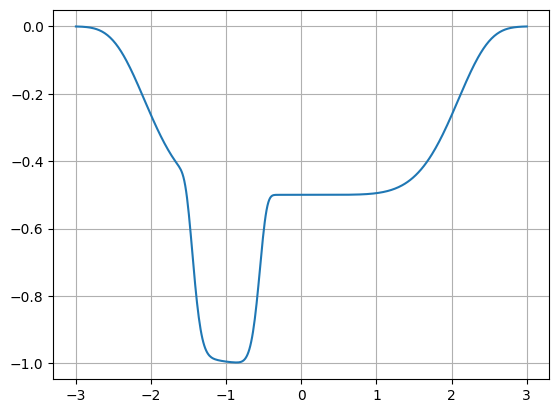

In [ ]:
@jax.jit
def custom_well(x):
    return - 0.5 * jnp.exp(-0.01 * x**6) - 0.5 * jnp.exp(-100*(x+1)**6)

x = jnp.linspace(-3, 3, 500)
plt.plot(x, custom_well(x))
plt.grid()
plt.show()

In [ ]:
layers = [1, 16, 16, 1]
activation = jax.nn.gelu
conf = 0.01
nopt = 401
nbins = 100
nchains = 400
nsamples_per_chain = 50
neq = 20
nskip = 10
sigma_step = 1.0
sigma_init = 1.0
learning_rate = 0.001
seed = 317
key = jax.random.PRNGKey(seed)

wavefunction = NeuralQuantumState(layers, activation, conf)
sampler = Sampler(nchains, nsamples_per_chain, neq, nskip, sigma_step, sigma_init, wavefunction)
hamiltonian = Hamiltonian(wavefunction, custom_well)
optimizer = Optimizer(learning_rate, wavefunction, sampler, hamiltonian)

key, subkey = jax.random.split(key)
params = wavefunction.build(subkey)

ti = time.time()
custom_well_training = optimizer.train(nopt, nbins, subkey, params)
tf = time.time()

print(f"Total training time = {tf-ti:10.3e} sec.")

Number of trainable parameters =  321

 iter      avg E      err E       time
    0 -3.460e-01  1.957e-03  4.847e+01
   10 -3.822e-01  1.812e-03  1.946e-03
   20 -4.148e-01  1.668e-03  6.042e-03
   30 -4.348e-01  1.479e-03  5.196e-03
   40 -4.575e-01  1.290e-03  5.292e-03
   50 -4.709e-01  1.123e-03  7.014e-04
   60 -4.781e-01  9.802e-04  4.967e-03
   70 -4.850e-01  8.882e-04  5.496e-03
   80 -4.879e-01  8.516e-04  5.199e-03
   90 -4.889e-01  8.302e-04  4.523e-03
  100 -4.903e-01  8.169e-04  7.060e-04
  110 -4.889e-01  8.177e-04  7.575e-04
  120 -4.895e-01  8.168e-04  6.635e-04
  130 -4.896e-01  8.149e-04  5.082e-03
  140 -4.900e-01  8.105e-04  5.468e-03
  150 -4.907e-01  8.068e-04  5.124e-03
  160 -4.901e-01  8.040e-04  6.583e-04
  170 -4.917e-01  7.925e-04  4.142e-03
  180 -4.892e-01  7.952e-04  6.480e-04
  190 -4.910e-01  7.906e-04  7.160e-04
  200 -4.889e-01  7.819e-04  8.659e-04
  210 -4.906e-01  7.710e-04  4.629e-03
  220 -4.907e-01  7.616e-04  6.733e-04
  230 -4.909e-01  7.569e-

In [ ]:
custom_well_anim = animate(custom_well_training, custom_well, skip=4)

In [ ]:
custom_well_anim

Experiment with your own potentials! Note: Double wells can be tricky if they're deep. Feel free to see for yourself!